In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.preprocessing as prep
from sklearn.model_selection import train_test_split
from model import AugementedConvLSTM
import h5py
import itertools

In [2]:
Aug_ConvLSTM_model = AugementedConvLSTM(
    projection_height = 129, 
    projection_width = 135,
    timesteps=4
    )
model = Aug_ConvLSTM_model.model(
    [32, 16, 16], 
    [9,5,3], 
    [64,32,1], 
    [9,3,5], 
    2
    )
model.load_weights('convlstm_weights_pr.h5')

2022-06-28 17:04:20.609358: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 17:04:23.443627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9631 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-06-28 17:04:23.445402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9631 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-06-28 17:04:23.446598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

In [3]:
def Process(i = 0, model = None, mask = [1,1,1,1,1], rf_idx = 1, end_index = 1000, show_plots = [1,1,1], Overwrite = False):
    def load_dataset():
        filepath = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data"
        rf = np.array(np.load(os.path.join(filepath,rf"r{rf_idx}.npy")))[:end_index,:,:]
        X = np.empty((7,end_index,129,135))
        X[0,:,:,:] = np.array(np.load(r"MIROC-ESM.npy"))[:end_index,:,:] if mask[0] else np.array(rf)
        X[1,:,:,:] = np.array(np.load(r"elev.npy"))[:end_index,:,:] if mask[1] else np.array(rf)
        X[2,:,:,:] = np.array(np.load(os.path.join(filepath,rf"rhum.npy")))[:end_index,:,:] if mask[2] else np.array(rf)
        X[3,:,:,:] = np.array(np.load(os.path.join(filepath,rf"pres.npy")))[:end_index,:,:] if mask[3] else np.array(rf)
        X[4,:,:,:] = np.array(np.load(os.path.join(filepath,rf"uwnd.npy")))[:end_index,:,:] if mask[4] else np.array(rf)
        X[5,:,:,:] = np.array(np.load(os.path.join(filepath,rf"vwnd.npy")))[:end_index,:,:] if mask[4] else np.array(rf)
        X[6,:,:,:] = np.array(np.load(os.path.join(filepath,rf"omega.npy")))[:end_index,:,:] if mask[4] else np.array(rf)
        # print(X.shape)
        Y = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]
        return X, Y
    def normalize(data):
        data = data - data.mean()
        data = data / data.std()
        return data
    def data_generator(X,Y):
        time_steps = 4
        batch_size1 = 1
        generator = prep.sequence.TimeseriesGenerator(
            X, 
            Y.reshape(-1, 129, 135, 1),
            length=time_steps, 
            batch_size=batch_size1
            )
        return generator
    def set_data(X, Y):
        X_normalized = np.zeros((7, end_index, 129, 135))
        for i in range(7):
            X_normalized[i,] = normalize(X[i,])
        Y_normalized = normalize(Y)
        # print("Mean of GCM Data: ",X[0,].mean())
        # print("Variance of GCM Data: ",X[0,].std(),end="\n")
        # print("Mean of Obseved Data: ",Y.mean())
        # print("Variance of Obseved Data: ",Y.std(),end="\n")
        std_observed = Y.std()
        # X = X_normalized.transpose(1,2,3,0)
        # Y = Y_normalized.reshape(-1,129, 135, 1)
        return data_generator(X_normalized.transpose(1,2,3,0), Y_normalized.reshape(-1,129, 135, 1))
    
    if not Overwrite:
        try:
            Y = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]
            yy_hat = np.load(rf"Data/yy_hat_{i}.npy")
            Y = normalize(Y).reshape(-1,129, 135, 1)
        except:
            X, Y = load_dataset()
            generator = set_data(X, Y)
            yy_hat = model.predict(generator)
            np.save(rf"Data/yy_hat_{i}.npy", yy_hat)
            del X, generator
    else:
        X, Y = load_dataset()
        generator = set_data(X, Y)
        yy_hat = model.predict(generator)
        np.save(rf"Data/yy_hat_{i}.npy", yy_hat)
        del X, generator
    
    calc = []

    Y_hat = np.array(yy_hat).reshape(-1,129,135)
    data = np.array(np.mean(Y_hat, axis = 0))
    print(f"Y_hat (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
    calc += [round(np.nanmin(data),3), round(np.nanmax(data),3), round(np.nanmean(data),3)]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    if show_plots[0]:
        fig,ax = plt.subplots(1,2, figsize = (20,10))
        sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
        ax[0].axis('off')
        ax[1].boxplot(data[~np.isnan(data)], vert = False)
        plt.show()
        del fig, ax
    del Y_hat, data, FileName, mask, indices

    Y_Obs = np.array(np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]).reshape(-1,129,135)[4:]
    Y_hat = np.array(yy_hat.reshape(-1,129,135))
    data = np.array(np.mean((Y_hat*Y_Obs.std())+Y_Obs.mean(), axis = 0))
    print(f"Y_hat (Scaled) (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
    calc += [round(np.nanmin(data),3), round(np.nanmax(data),3), round(np.nanmean(data),3)]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    data[indices] = np.nan
    if show_plots[1]:
        fig,ax = plt.subplots(1,2, figsize = (20,10))
        sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
        ax[0].axis('off')
        ax[1].boxplot(data[~np.isnan(data)], vert = False)
        plt.show()
        del fig, ax
    del Y_hat, Y_Obs, data, FileName, mask, indices

    Y_Obs = np.array(np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]).reshape(-1,129,135)[4:]
    Y_hat = np.array(yy_hat.reshape(-1,129,135))
    data = np.array(np.sqrt(np.sum(np.square(((Y_hat*Y_Obs.std())+Y_Obs.mean()) - Y_Obs), axis = 0)/Y_hat.shape[0]))
    print(f"RMSE (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
    calc += [round(np.nanmin(data),3), round(np.nanmax(data),3), round(np.nanmean(data),3)]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    threshold_99 = np.nanpercentile(data, 99)
    indices = np.where(data > threshold_99)
    data[indices] = np.nan
    if show_plots[2]:
        fig,ax = plt.subplots(1,2, figsize = (20,10))
        sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
        ax[0].axis('off')
        ax[1].boxplot(data[~np.isnan(data)], vert = False)
        plt.show()
        del fig, ax
    del Y_hat, Y_Obs, data, FileName, mask, indices, threshold_99

    return calc
mask_calc = {}

In [4]:
mask_list = [ # Pr, elev, rh, p, wnd
    [1,1,1,1,1], 
    [1,0,1,1,1],
    [1,1,0,1,1],
    [1,1,1,0,1],
    [1,1,1,1,0],
    [0,1,1,1,0],
    [0,1,1,0,1],
    [0,1,0,1,1],
    [0,1,1,0,0],
    [0,1,0,0,1],
    [0,1,0,1,0]
]

In [ ]:
# for idx, i in itertools.islice(enumerate(mask_list),0,None,1):
#     print(idx, i)
#     mask_calc[str(i)]= Process(
#         i = idx, 
#         model = model, 
#         mask = i, 
#         rf_idx = 1, 
#         end_index = 365,
#         show_plots = [0,0,0],
#         Overwrite = False
#         )
#     print("*****************************************************************")

In [ ]:
for idx, i in itertools.islice(enumerate(mask_list),0,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [0,0,0],
        Overwrite = False
        )
    print("*****************************************************************")

In [ ]:
for idx, i in itertools.islice(enumerate(mask_list),0,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [1,0,0],
        Overwrite = False
        )
    print("*****************************************************************")

In [ ]:
for idx, i in itertools.islice(enumerate(mask_list),0,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [0,1,0],
        Overwrite = False
        )
    print("*****************************************************************")

0 [1, 1, 1, 1, 1]
Y_hat (Min, Max, Mean) = (-0.23800000548362732, 3.943000078201294, -0.014000000432133675) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.5139999985694885, 24.187000274658203, 0.8100000023841858) mm/day
RMSE (Min, Max, Mean) = (0.045, 46.692, 2.623) mm/day


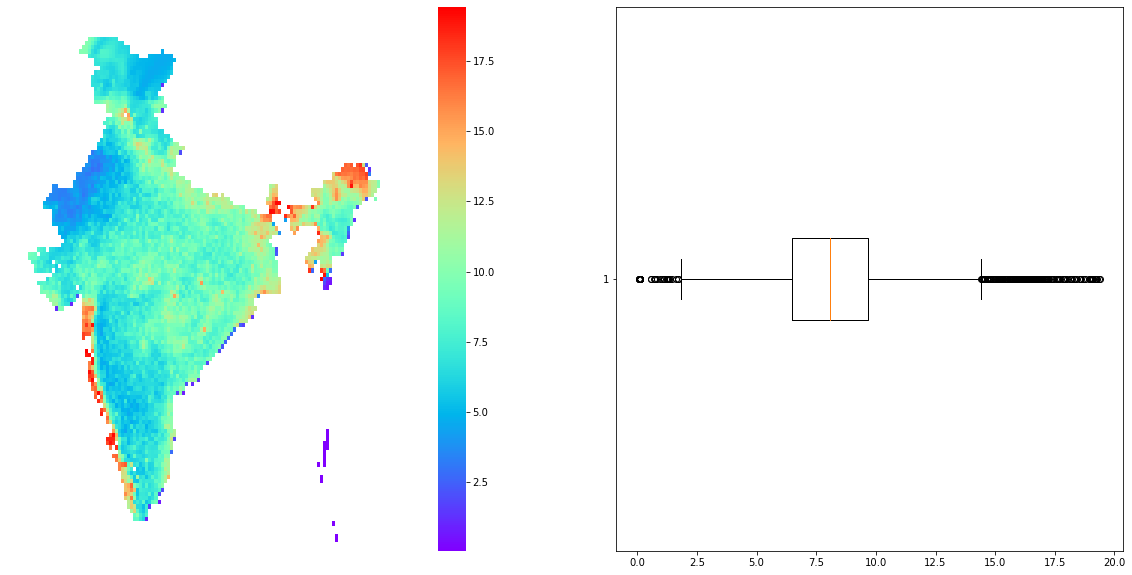

*****************************************************************
1 [1, 0, 1, 1, 1]
Y_hat (Min, Max, Mean) = (-0.1420000046491623, 0.5789999961853027, 0.1379999965429306) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (0.0560000017285347, 4.315999984741211, 1.7109999656677246) mm/day
RMSE (Min, Max, Mean) = (0.279, 55.31, 5.35) mm/day


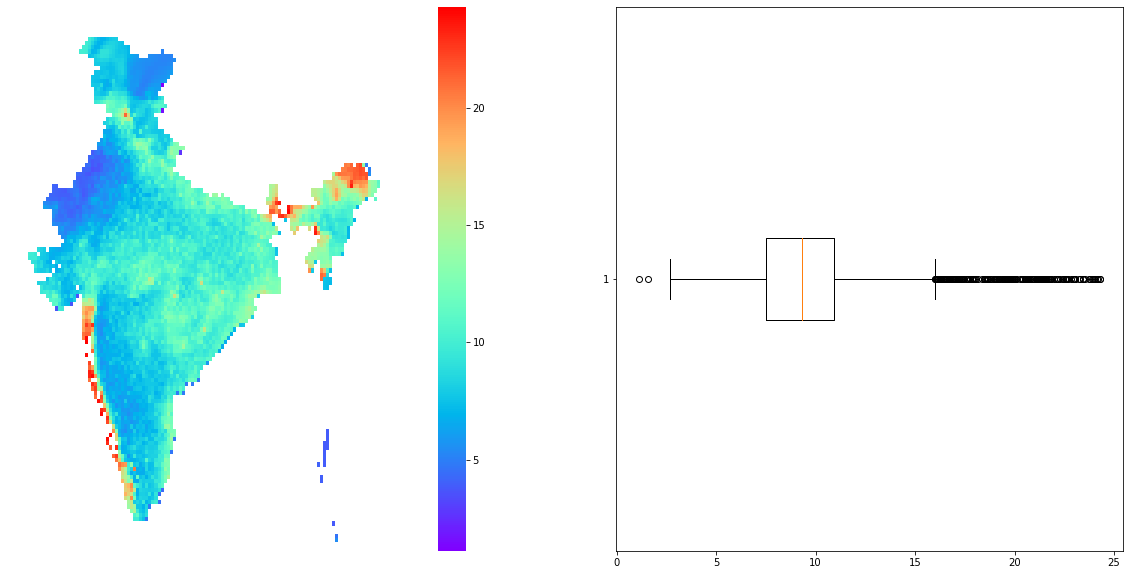

*****************************************************************
2 [1, 1, 0, 1, 1]
Y_hat (Min, Max, Mean) = (-0.19699999690055847, 1.093000054359436, -0.0010000000474974513) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.26899999380111694, 7.349999904632568, 0.8899999856948853) mm/day
RMSE (Min, Max, Mean) = (0.045, 53.5, 3.13) mm/day


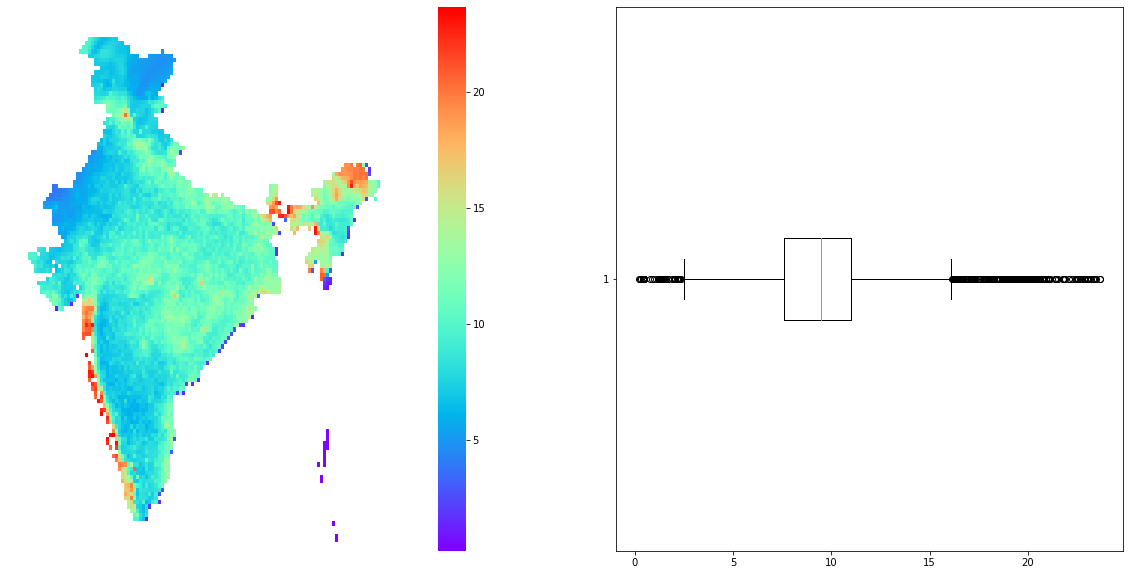

*****************************************************************
3 [1, 1, 1, 0, 1]
Y_hat (Min, Max, Mean) = (-0.16099999845027924, 1.2669999599456787, 0.11599999666213989) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.057999998331069946, 8.378000259399414, 1.5809999704360962) mm/day
RMSE (Min, Max, Mean) = (0.514, 54.651, 4.945) mm/day


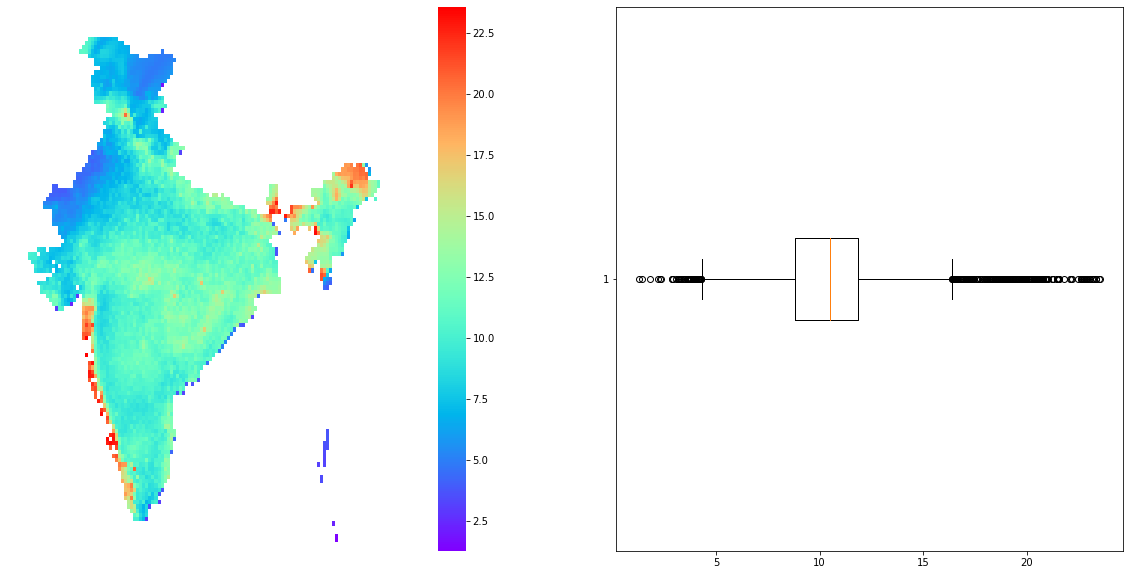

*****************************************************************
4 [1, 1, 1, 1, 0]
Y_hat (Min, Max, Mean) = (-0.20399999618530273, 2.4230000972747803, 0.0689999982714653) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.3109999895095825, 15.206999778747559, 1.3029999732971191) mm/day
RMSE (Min, Max, Mean) = (0.04, 55.614, 3.617) mm/day


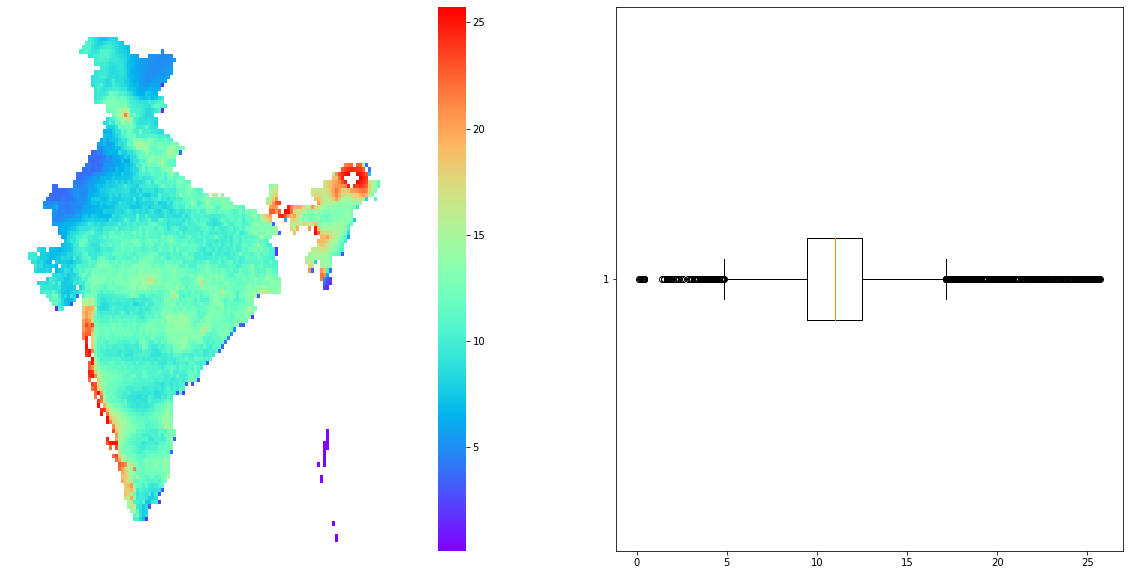

*****************************************************************
5 [0, 1, 1, 1, 0]
Y_hat (Min, Max, Mean) = (-0.20200000703334808, 2.4519999027252197, 0.0689999982714653) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.29899999499320984, 15.378000259399414, 1.2979999780654907) mm/day
RMSE (Min, Max, Mean) = (0.044, 55.648, 3.604) mm/day


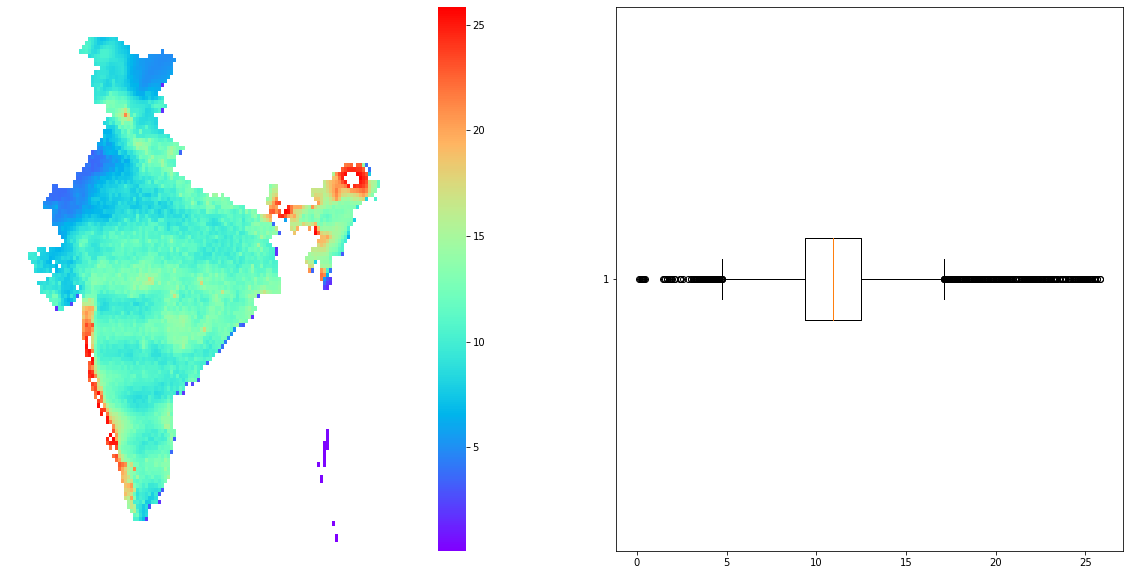

*****************************************************************
6 [0, 1, 1, 0, 1]
Y_hat (Min, Max, Mean) = (-0.16200000047683716, 1.2910000085830688, 0.12300000339746475) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.06599999964237213, 8.517000198364258, 1.621000051498413) mm/day
RMSE (Min, Max, Mean) = (0.564, 54.686, 5.01) mm/day


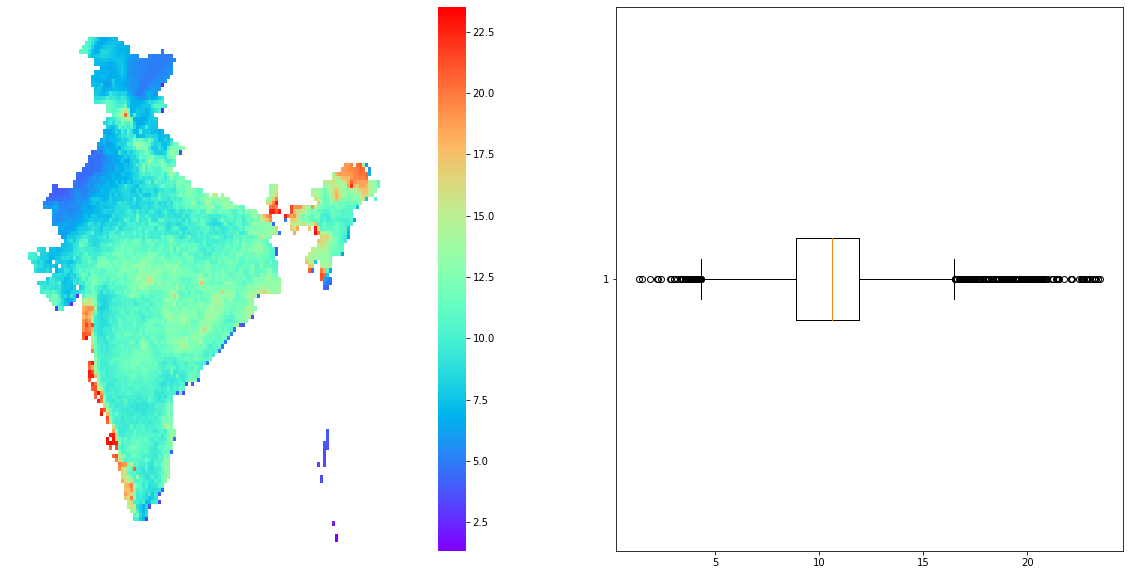

*****************************************************************
7 [0, 1, 0, 1, 1]
Y_hat (Min, Max, Mean) = (-0.19699999690055847, 1.0950000286102295, 0.0) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.2720000147819519, 7.361999988555908, 0.8939999938011169) mm/day
RMSE (Min, Max, Mean) = (0.047, 53.424, 3.128) mm/day


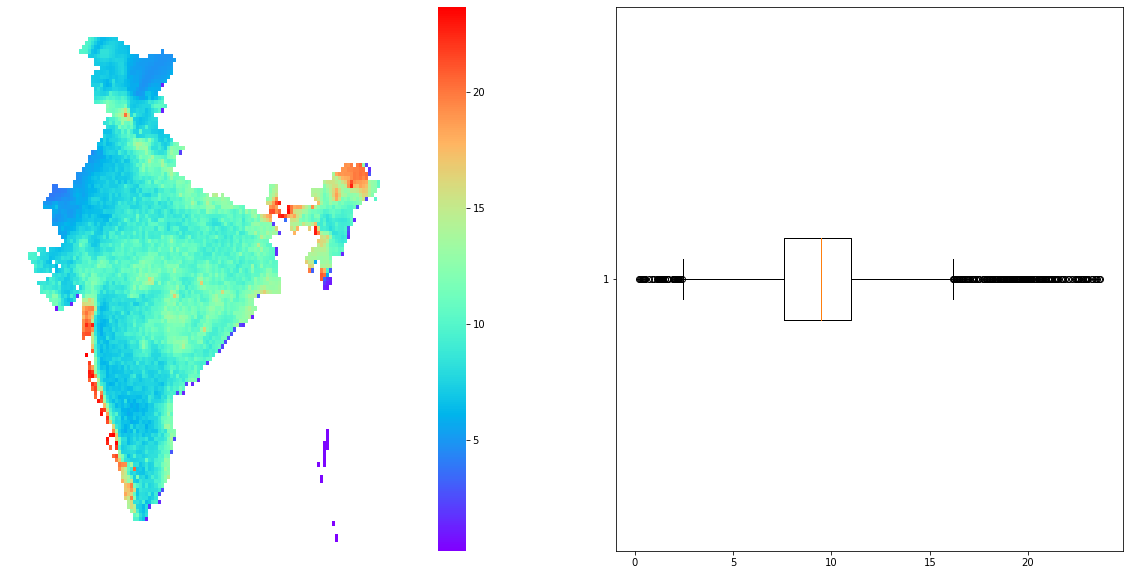

*****************************************************************
8 [0, 1, 1, 0, 0]
Y_hat (Min, Max, Mean) = (-0.14000000059604645, 1.628999948501587, 0.13500000536441803) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (0.06300000101327896, 10.512999534606934, 1.6920000314712524) mm/day
RMSE (Min, Max, Mean) = (0.474, 56.001, 5.191) mm/day


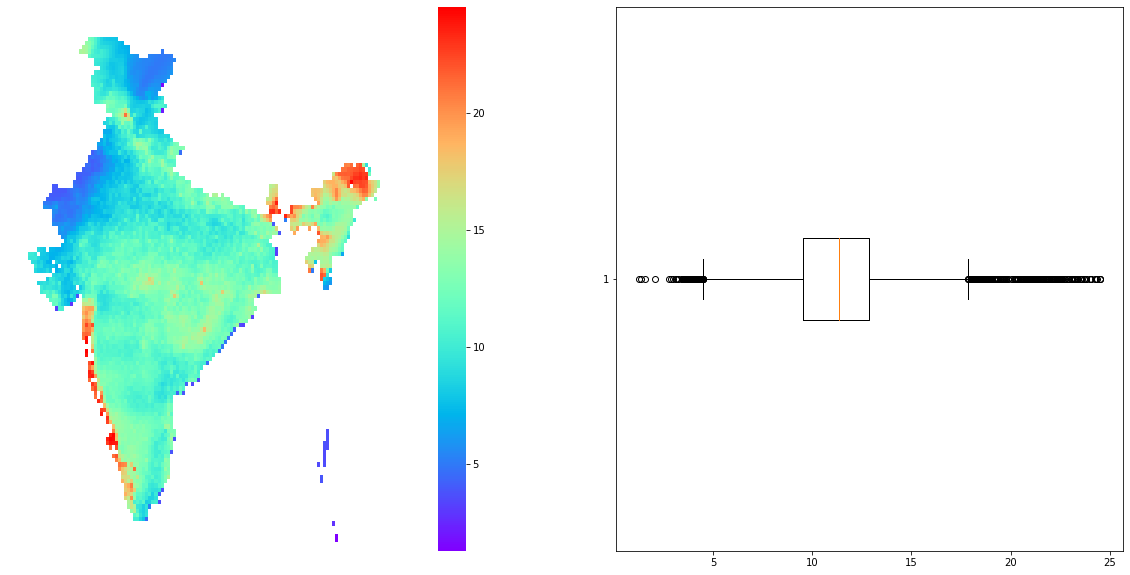

*****************************************************************
9 [0, 1, 0, 0, 1]
Y_hat (Min, Max, Mean) = (-0.14100000262260437, 1.152999997138977, 0.09799999743700027) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (0.05900000035762787, 7.705999851226807, 1.4730000495910645) mm/day
RMSE (Min, Max, Mean) = (0.576, 56.5, 5.252) mm/day


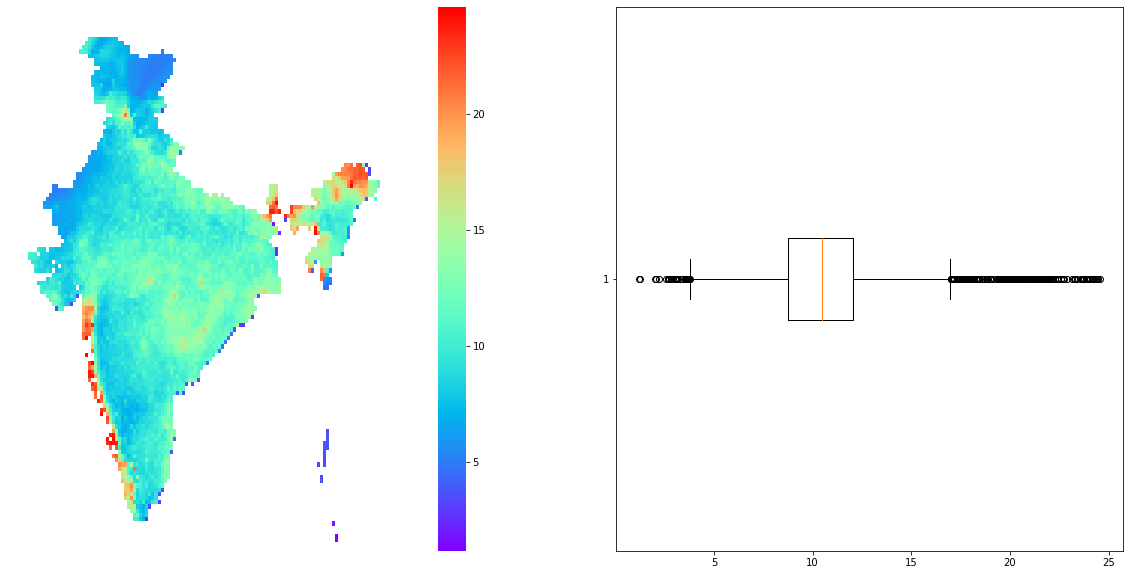

*****************************************************************
10 [0, 1, 0, 1, 0]
Y_hat (Min, Max, Mean) = (-0.17900000512599945, 1.8140000104904175, 0.1509999930858612) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.16599999368190765, 11.607999801635742, 1.7860000133514404) mm/day
RMSE (Min, Max, Mean) = (0.056, 57.263, 4.574) mm/day


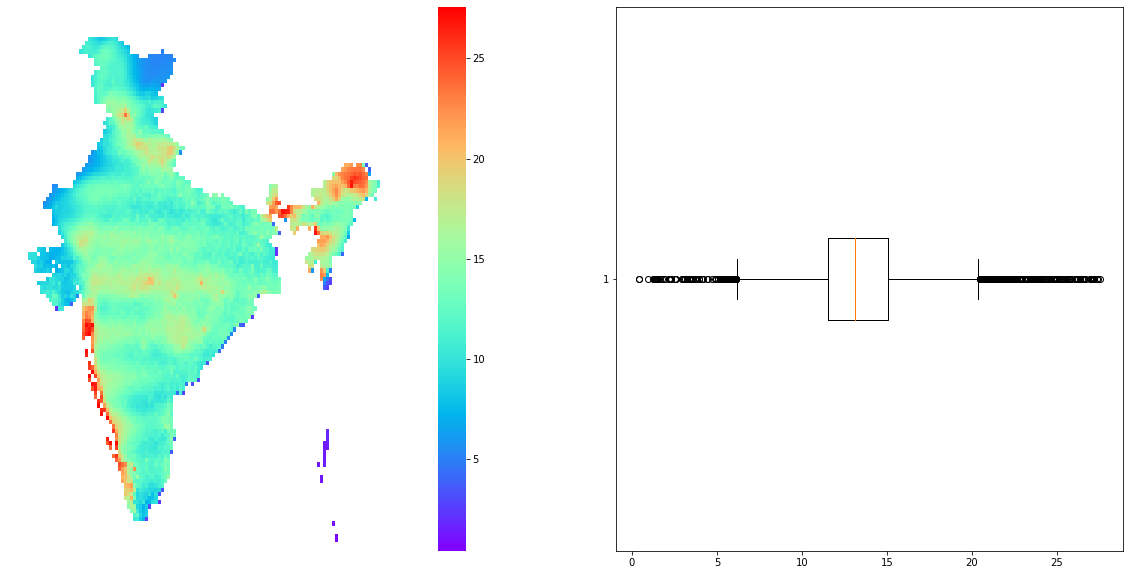

*****************************************************************


In [8]:
for idx, i in itertools.islice(enumerate(mask_list),0,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [0,0,1],
        Overwrite = False
        )
    print("*****************************************************************")

In [4]:
mask_list = [ # Pr, elev, rh, p, wnd
    [1,1,1,1,1], 
    [1,0,1,1,1],
    [1,1,0,1,1],
    [1,1,1,0,1],
    [1,1,1,1,0],
    [0,1,1,1,0],
    [0,1,1,0,1],
    [0,1,0,1,1],
    [0,1,1,0,0],
    [0,1,0,0,1],
    [0,1,0,1,0], ###############
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,0,1,0],
    [0,0,0,0,1],
    [1,0,0,0,0],
    [0,0,0,0,0]
]

In [13]:
for idx, i in itertools.islice(enumerate(mask_list),11,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [0,0,0],
        Overwrite = False
        )
    print("*****************************************************************")

11 [0, 1, 0, 0, 0]
Y_hat (Min, Max, Mean) = (-0.12800000607967377, 1.4259999990463257, 0.2150000035762787) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (0.13600000739097595, 9.3149995803833, 2.1630001068115234) mm/day
RMSE (Min, Max, Mean) = (0.572, 56.992, 6.021) mm/day
*****************************************************************
12 [0, 0, 1, 0, 0]
Y_hat (Min, Max, Mean) = (0.06599999964237213, 1.2139999866485596, 0.6909999847412109) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (1.284000039100647, 8.064000129699707, 4.97599983215332) mm/day
RMSE (Min, Max, Mean) = (2.544, 56.576, 10.673) mm/day
*****************************************************************
13 [0, 0, 0, 1, 0]
Y_hat (Min, Max, Mean) = (-0.12999999523162842, 0.8429999947547913, 0.4269999861717224) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (0.12399999797344208, 5.872000217437744, 3.4179999828338623) mm/day
RMSE (Min, Max, Mean) = (0.42, 57.081, 8.363) mm/day
*****************************************************************

11 [0, 1, 0, 0, 0]
Y_hat (Min, Max, Mean) = (-0.12800000607967377, 1.4259999990463257, 0.2150000035762787) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (0.13600000739097595, 9.3149995803833, 2.1630001068115234) mm/day
RMSE (Min, Max, Mean) = (0.572, 56.992, 6.021) mm/day


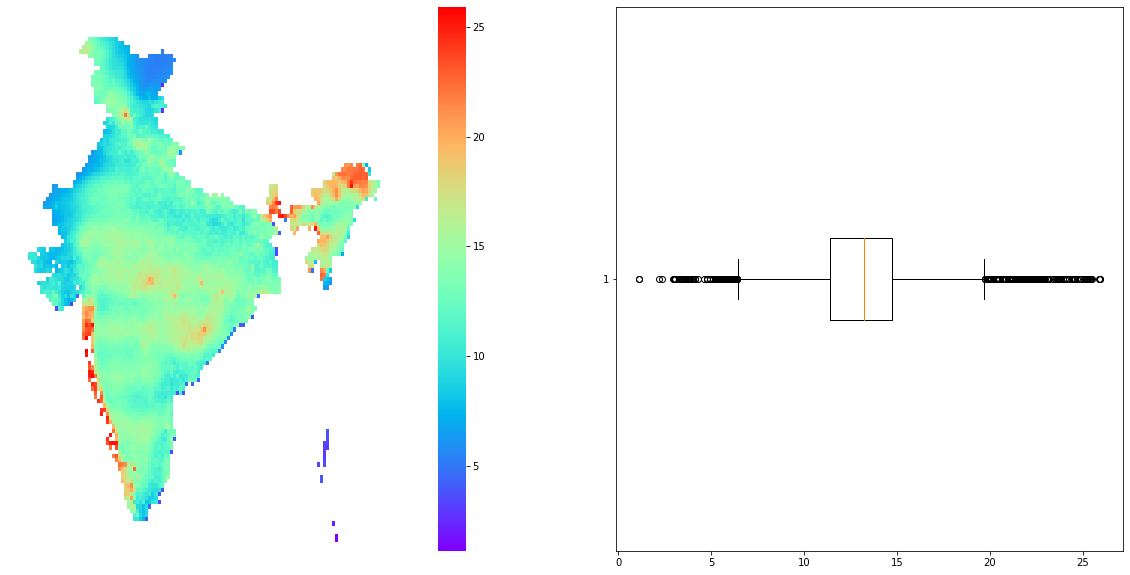

*****************************************************************
12 [0, 0, 1, 0, 0]
Y_hat (Min, Max, Mean) = (0.06599999964237213, 1.2139999866485596, 0.6909999847412109) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (1.284000039100647, 8.064000129699707, 4.97599983215332) mm/day
RMSE (Min, Max, Mean) = (2.544, 56.576, 10.673) mm/day


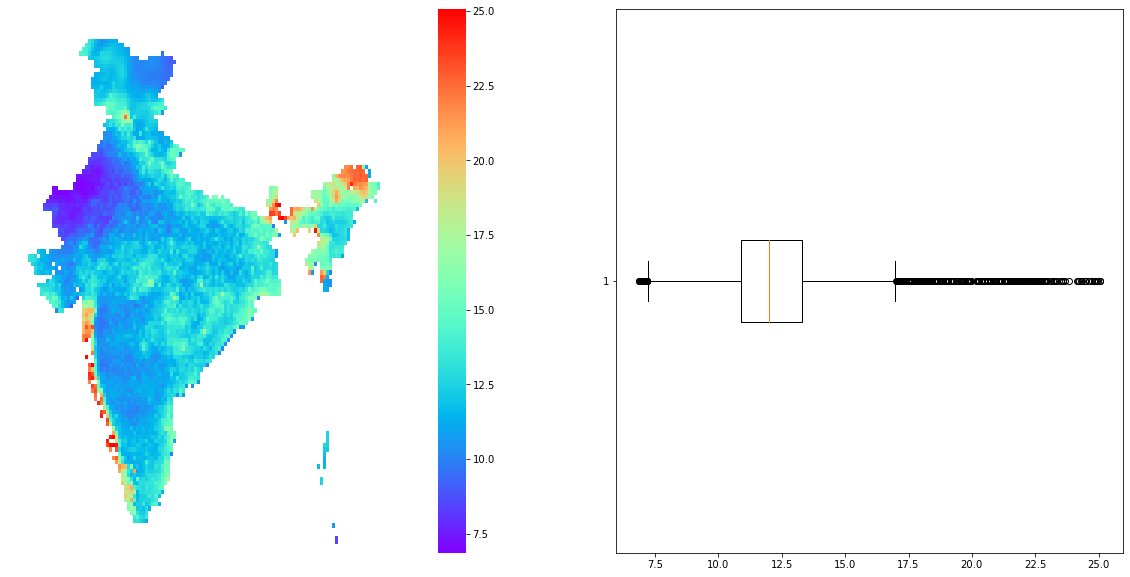

*****************************************************************
13 [0, 0, 0, 1, 0]
Y_hat (Min, Max, Mean) = (-0.12999999523162842, 0.8429999947547913, 0.4269999861717224) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (0.12399999797344208, 5.872000217437744, 3.4179999828338623) mm/day
RMSE (Min, Max, Mean) = (0.42, 57.081, 8.363) mm/day


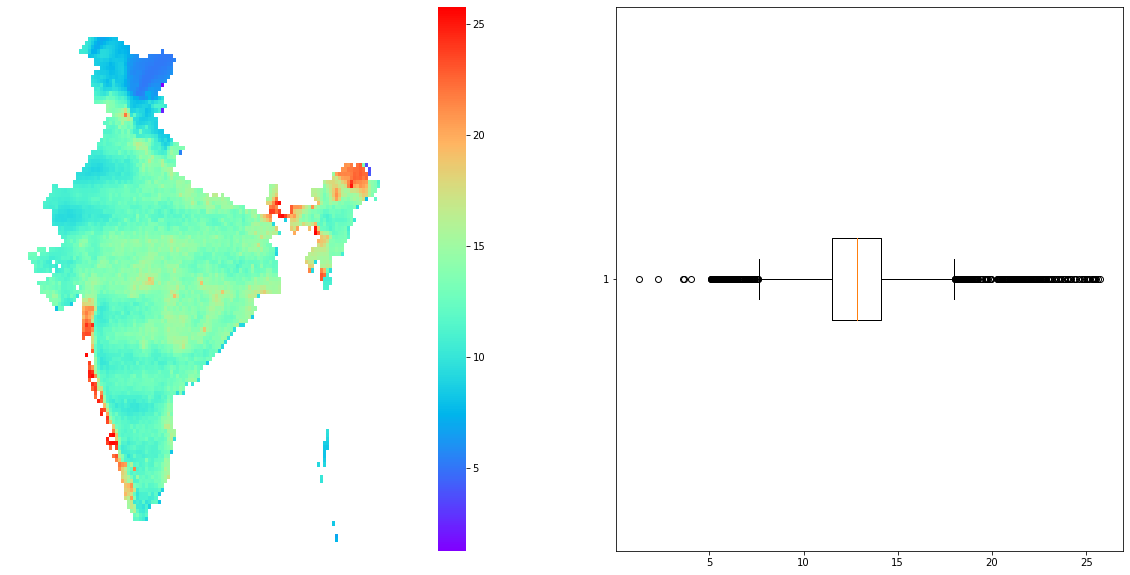

*****************************************************************
14 [0, 0, 0, 0, 1]
Y_hat (Min, Max, Mean) = (0.023000000044703484, 1.0859999656677246, 0.6150000095367432) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (1.0299999713897705, 7.307000160217285, 4.5289998054504395) mm/day
RMSE (Min, Max, Mean) = (2.662, 56.554, 9.557) mm/day


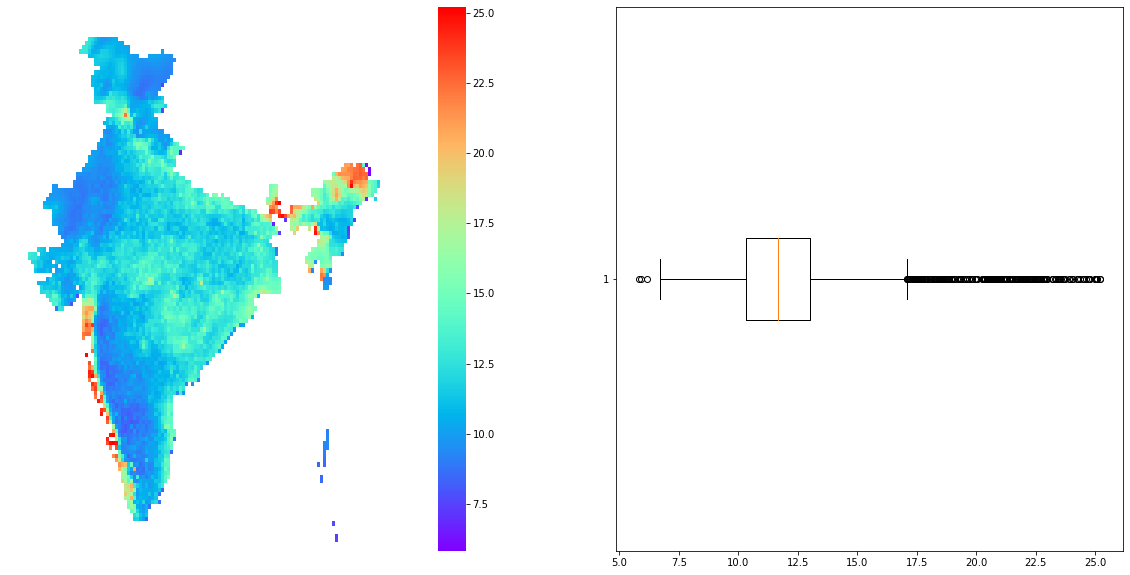

*****************************************************************
15 [1, 0, 0, 0, 0]
Y_hat (Min, Max, Mean) = (0.12399999797344208, 1.2489999532699585, 0.7820000052452087) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (1.6230000257492065, 8.27299976348877, 5.511000156402588) mm/day
RMSE (Min, Max, Mean) = (2.634, 57.281, 12.211) mm/day


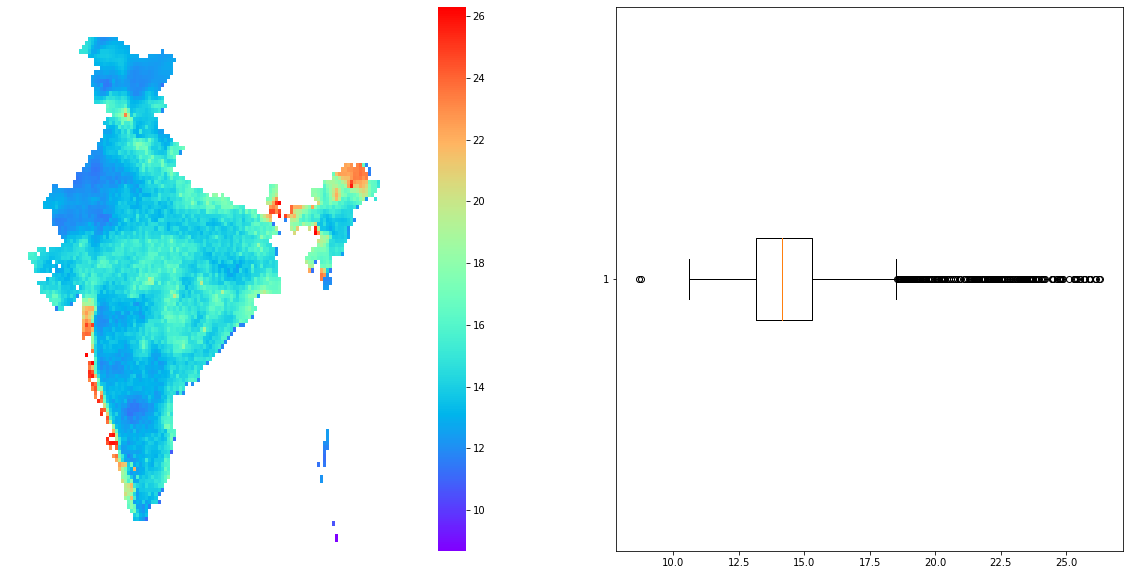

*****************************************************************
16 [0, 0, 0, 0, 0]
Y_hat (Min, Max, Mean) = (0.12999999523162842, 1.3480000495910645, 0.8489999771118164) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (1.6619999408721924, 8.859000205993652, 5.9070000648498535) mm/day
RMSE (Min, Max, Mean) = (2.656, 57.353, 13.035) mm/day


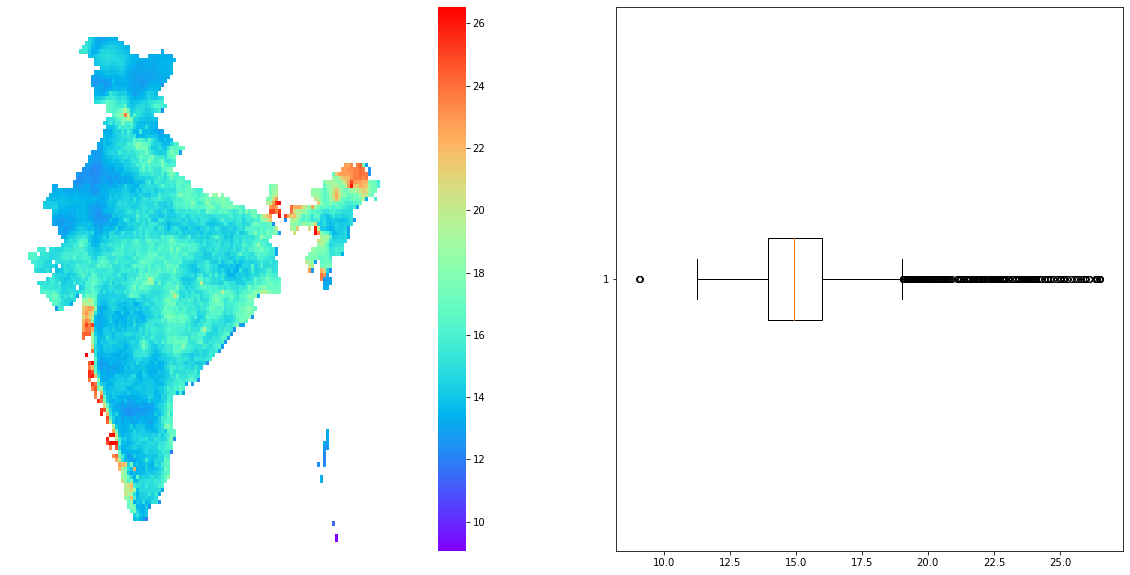

*****************************************************************


In [14]:
for idx, i in itertools.islice(enumerate(mask_list),11,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [0,0,1],
        Overwrite = False
        )
    print("*****************************************************************")

0 [1, 1, 1, 1, 1]
Y_hat (Min, Max, Mean) = (-0.23800000548362732, 3.943000078201294, -0.014000000432133675) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.5139999985694885, 24.187000274658203, 0.8100000023841858) mm/day


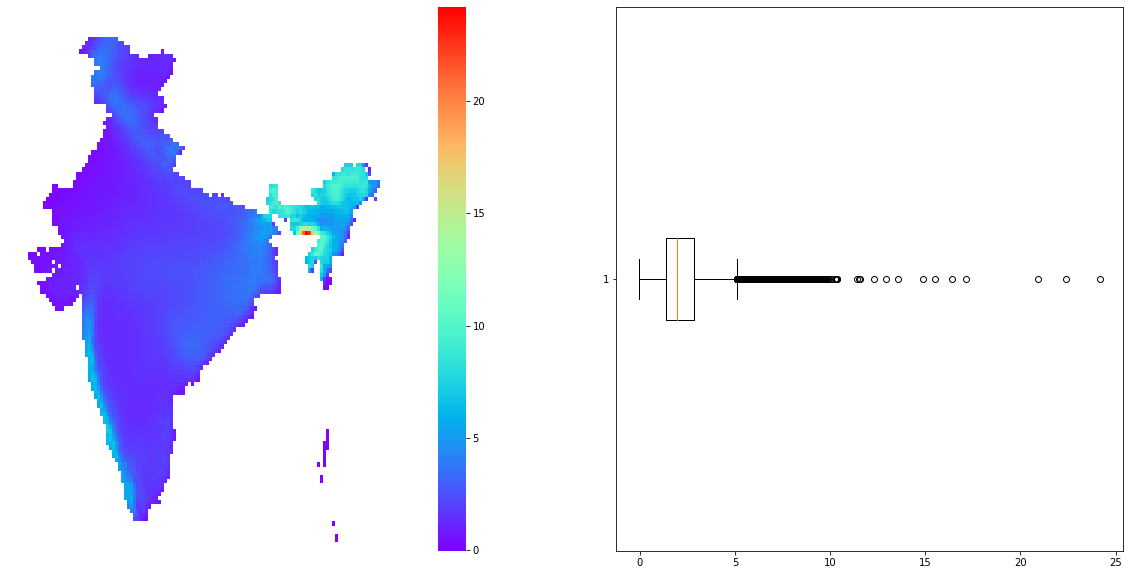

RMSE (Min, Max, Mean) = (0.045, 46.692, 2.623) mm/day
*****************************************************************
1 [1, 0, 1, 1, 1]
Y_hat (Min, Max, Mean) = (-0.1420000046491623, 0.5789999961853027, 0.1379999965429306) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (0.0560000017285347, 4.315999984741211, 1.7109999656677246) mm/day


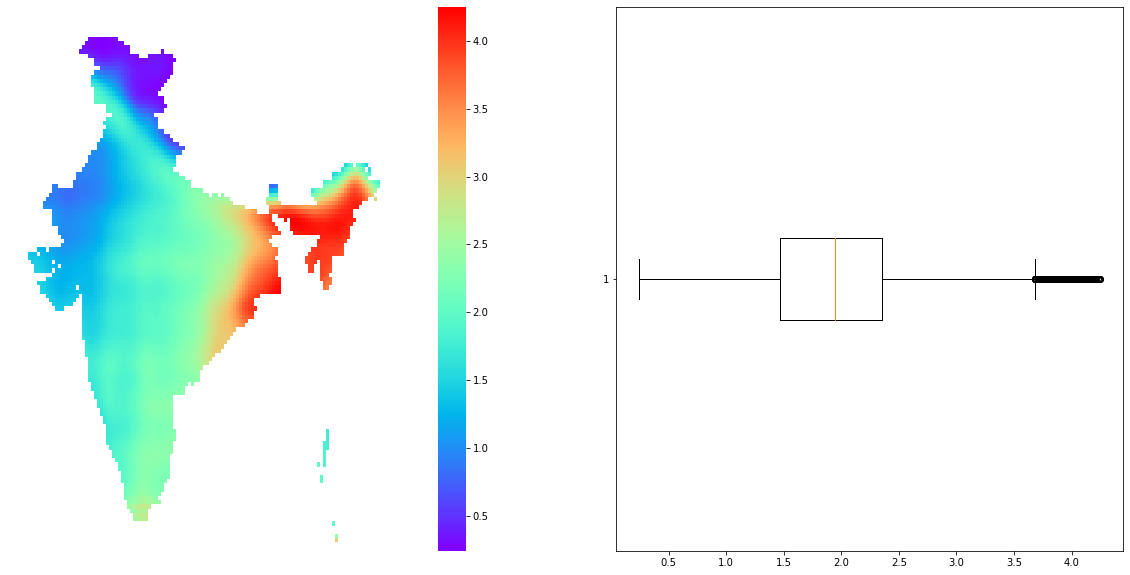

RMSE (Min, Max, Mean) = (0.279, 55.31, 5.35) mm/day
*****************************************************************


In [5]:
for idx, i in itertools.islice(enumerate(mask_list),0,2,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [0,1,0],
        Overwrite = False
        )
    print("*****************************************************************")